In [1]:
!pip3 install nufeb-tools -U --quiet

In [2]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from skopt import dump, load
from skopt.callbacks import CheckpointSaver

In [3]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)
#popt, pcov = curve_fit(suc_func, test_data.IPTG, test_data.Sucrose)
    #Compare output with experimental data
#OD = interpolate.interp1d(test_data.IPTG,test_data.OD750)
#Sucrose = interpolate.interp1d(test_data.IPTG,test_data.Sucrose)
#sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
#x_range = np.arange(0,1,.01)
#plt.plot(x_range,suc_func(x_range))
#plt.plot(test_data.IPTG,test_data.Sucrose,marker='o')
#plt.plot(x_range, suc_func(x_range, *popt), 'r-')
#xr = np.array([0.001,.01,.05,0.2,1])
#plt.plot(xr,suc_func(xr, *popt),marker='s',ls='')
#plt.plot(x_range,od_func(x_range))
#residual = abs(r2_score(exp(x_range),sim(x_range))-1)

In [4]:
# Base install of NUFEB
os.chdir('/tmp')
os.system('git clone https://github.com/Jsakkos/NUFEB --recursive')
os.chdir('NUFEB')
os.system('git checkout cyano')
initial_compile = subprocess.run('/home/12x/init-compile.sh')


In [5]:
#nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')


In [6]:
def recompile(alpha,tau,c,alpha2,tau2,c2):
    os.chdir('/tmp/NUFEB')
    filein = open( f'/home/12x/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
                                        
                                        })
    with open("/tmp/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp","w") as f:
       f.writelines(result)
    #Compile NUFEB
    nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')

In [7]:
def test_run():
    os.chdir('/tmp/NUFEB')
    os.system('nufeb-clean')
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700'
    os.system(text)
    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)

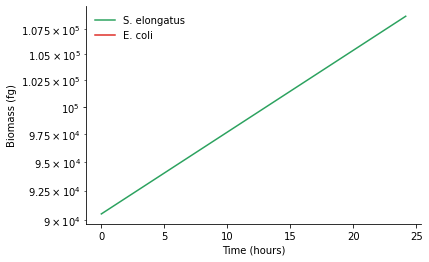

In [8]:
# Test to make sure everything is working
recompile(.18,.07,.8,.79,9.9,.01)
test_run()
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
f, ax = plt.subplots()
plot.overall_growth(data[0].biomass,ax=ax)
plt.show()

In [9]:
from tqdm.notebook import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [10]:
def func(x):

    alpha = x[0]
    tau = x[1]
    c = x[2]
    #alpha2= 0.7917548932118175
    #tau2= 9.928116064234674
    #c2= 0.017154626440951674
    alpha2 = x[3]
    tau2 = x[4]
    c2 = x[5]
    mu = x[6]





    #Change input params
    
    os.chdir('/tmp/NUFEB')
    recompile(alpha,tau,c,alpha2,tau2,c2)
    print(f'alpha: {alpha},tau: {tau},c: {c},alpha2: {alpha2},tau2: {tau2},c2: {c2}, mu: {mu}')

    #Clean old simulations
    os.system('nufeb-clean')
    #Run simulation
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --sucR {iptg}'
        os.system(text)

    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-4 #m^3
    CellNum2OD = Volume*1e6/0.3e-8
    SucroseMW = 342.3
    dfs = []
    for x in data:
        temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
        temp.columns=['OD750','Hours','Sucrose']
        temp['IPTG'] = x.metadata['SucRatio']
        dfs.append(temp)
    df = pd.concat(dfs,ignore_index=True)
    df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
    df.sort_values(by='IPTG',inplace=True)
    df.reset_index(inplace=True)
    
    #plot
    f, ax = plt.subplots(ncols=2)
    ax[0].set_title('Sucrose')
    ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
    ax[0].plot(df.IPTG,df.Sucrose)
    ax[1].set_title('OD750')
    ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
    ax[1].plot(df.IPTG,df.OD750)
    plt.show()
    #Compare output with experimental data via RMSE
    
    return mean_squared_error(df.OD750,test_data.OD750, squared = False) + mean_squared_error(df.Sucrose,test_data.Sucrose, squared = False)




In [13]:
res = load('/home/12x/nufeb-cyano-e-coli/checkpoints/checkpoint.pkl')
x0 = res.x_iters
y0 = res.func_vals
          #  x0=x0,              # already examined values for x
       #     y0=y0,              # observed values for x0

Iteration No: 1 started. Evaluating function at random point.
alpha: -0.045201816632525066,tau: 0.06104908543962338,c: 0.15999662871933443,alpha2: -0.11057977650929018,tau2: 0.08633833443229394,c2: 1.6376757173440424, mu: 4.106023205329874e-05


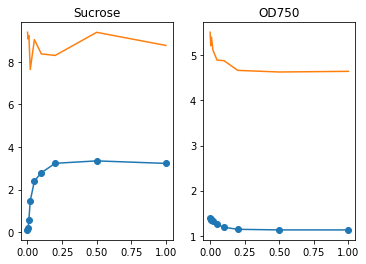

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 315.0784
Function value obtained: 10.7909
Current minimum: 10.7909
Iteration No: 2 started. Evaluating function at random point.
alpha: -0.07743361611191167,tau: 0.05827720310658798,c: 0.123876780950164,alpha2: -1.391362046784026,tau2: 0.0812647825996726,c2: 0.6033167448938965, mu: 4.833006633879742e-06


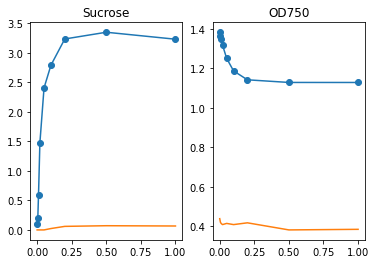

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 184.5351
Function value obtained: 3.1274
Current minimum: 3.1274
Iteration No: 3 started. Evaluating function at random point.
alpha: -0.08670197259236108,tau: 0.08613284958944695,c: 0.16435053408459013,alpha2: -3.239273893249412,tau2: 0.07219042699271322,c2: 2.304367265673047, mu: 4.493476848926817e-05


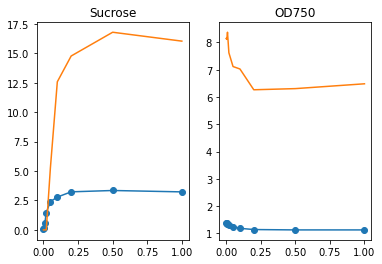

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 307.3778
Function value obtained: 14.1214
Current minimum: 3.1274
Iteration No: 4 started. Evaluating function at random point.
alpha: -0.10552976305680595,tau: 0.09814637962850886,c: 0.05832136636663883,alpha2: -4.160160578679418,tau2: 0.02624977945622218,c2: 3.5095895996724353, mu: 6.448378676386861e-06


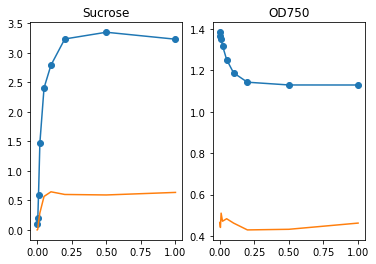

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 190.5227
Function value obtained: 2.6475
Current minimum: 2.6475
Iteration No: 5 started. Evaluating function at random point.
alpha: -0.0904144665130024,tau: 0.08084352973494077,c: 0.46854356201857555,alpha2: -2.009028679884776,tau2: 0.020041137220591115,c2: 3.1307900112515705, mu: 1.140985168554651e-05


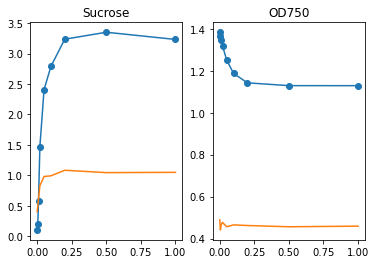

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 203.5755
Function value obtained: 2.3030
Current minimum: 2.3030
Iteration No: 6 started. Evaluating function at random point.
alpha: -0.10945365230495784,tau: 0.010875771664789285,c: 0.36600742060965064,alpha2: -4.826134615674883,tau2: 0.07468957464396285,c2: 3.6067451994598954, mu: 7.676565801810988e-06


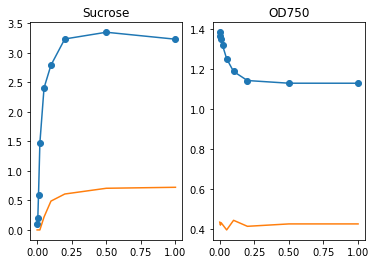

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 211.9740
Function value obtained: 2.7425
Current minimum: 2.3030
Iteration No: 7 started. Evaluating function at random point.
alpha: -0.19778785660342568,tau: 0.03858697994232039,c: 0.4679488282258046,alpha2: -3.313747788893009,tau2: 0.027444290227253226,c2: 3.0216748272270397, mu: 8.641525417008508e-06


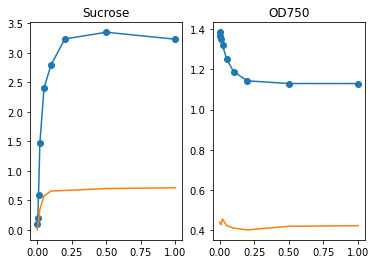

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 193.6075
Function value obtained: 2.6338
Current minimum: 2.3030
Iteration No: 8 started. Evaluating function at random point.
alpha: -0.08508549465937475,tau: 0.07010552931314262,c: 0.2123008128966834,alpha2: -4.993095027264927,tau2: 0.07409074958273305,c2: 2.0499291978143734, mu: 3.051776432266379e-05


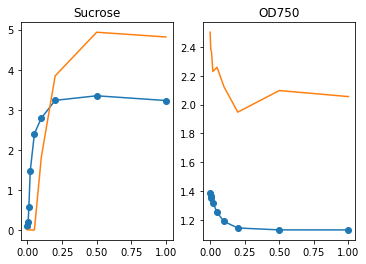

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 301.6416
Function value obtained: 2.2492
Current minimum: 2.2492
Iteration No: 9 started. Evaluating function at random point.
alpha: -0.1414351413292076,tau: 0.02172691013456019,c: 0.37103784791804795,alpha2: -1.7820505319687192,tau2: 0.05411304560294008,c2: 3.957363393933728, mu: 3.423255555708745e-05


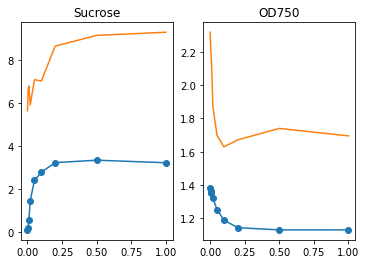

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 302.9444
Function value obtained: 6.1341
Current minimum: 2.2492
Iteration No: 10 started. Evaluating function at random point.
alpha: -0.03690478907067235,tau: 0.06409953468324106,c: 0.04559477761233122,alpha2: -4.618069034781089,tau2: 0.03733399115317529,c2: 1.8208527687461693, mu: 2.823820133821646e-05


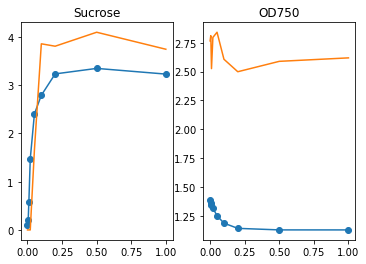

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 290.1380
Function value obtained: 2.2024
Current minimum: 2.2024
Iteration No: 11 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 4.3824415180614, mu: 2.2981090382599035e-05


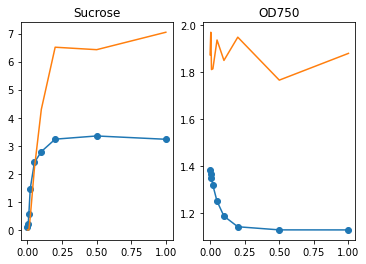

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 278.6931
Function value obtained: 2.7008
Current minimum: 2.2024
Iteration No: 12 started. Searching for the next optimal point.
alpha: -0.05850570156653054,tau: 0.07200537291290535,c: 0.12274461748431305,alpha2: -5.0,tau2: 0.058433485129980804,c2: 1.7512060736340729, mu: 2.927361364226496e-05


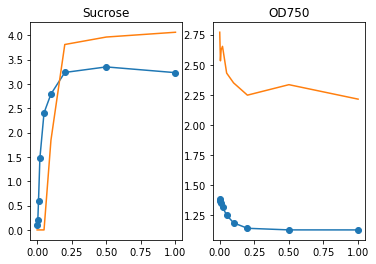

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 290.2912
Function value obtained: 2.3015
Current minimum: 2.2024
Iteration No: 13 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.0443423499179263,c: 0.5,alpha2: -5.0,tau2: 0.1,c2: 0.0, mu: 1.9849630557403694e-05


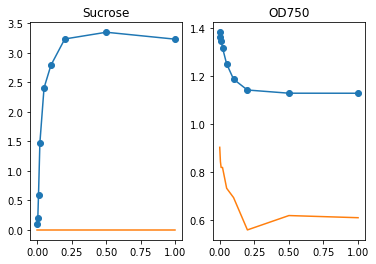

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 260.8099
Function value obtained: 2.8342
Current minimum: 2.2024
Iteration No: 14 started. Searching for the next optimal point.
alpha: -0.04750919457077424,tau: 0.08125394144294117,c: 0.09420191526334096,alpha2: -5.0,tau2: 0.05489899713551472,c2: 1.4266786055322527, mu: 2.8502509146396917e-05


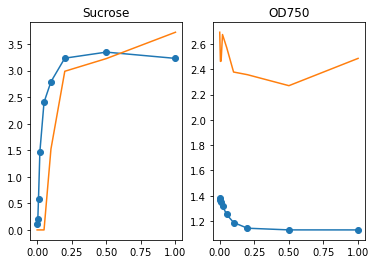

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 290.9596
Function value obtained: 2.3070
Current minimum: 2.2024
Iteration No: 15 started. Searching for the next optimal point.
alpha: -0.044695817326070586,tau: 0.05422494240373871,c: 0.07431810461916469,alpha2: -4.20967071803223,tau2: 0.033271938654638865,c2: 2.325113496377343, mu: 2.7971288515847193e-05


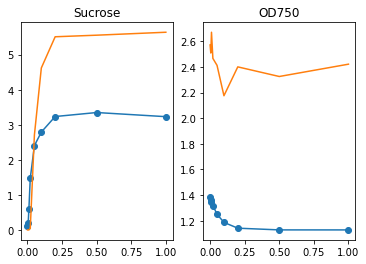

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 276.4987
Function value obtained: 2.7454
Current minimum: 2.2024
Iteration No: 16 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.019648536412052123,c: 0.0,alpha2: 0.0,tau2: 0.01,c2: 0.0, mu: 1.757944117394202e-05


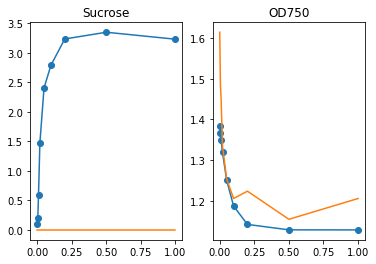

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 169.7361
Function value obtained: 2.4161
Current minimum: 2.2024
Iteration No: 17 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.5,alpha2: -5.0,tau2: 0.01,c2: 5.0, mu: 1e-06


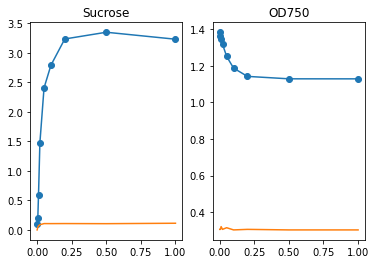

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 108.9898
Function value obtained: 3.1772
Current minimum: 2.2024
Iteration No: 18 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: 0.0,tau2: 0.01,c2: 0.0, mu: 1.299692672884074e-05


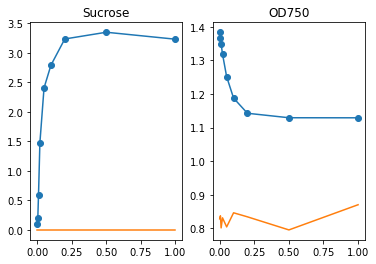

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 146.1554
Function value obtained: 2.7522
Current minimum: 2.2024
Iteration No: 19 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -2.24282510252704,tau2: 0.01,c2: 5.0, mu: 1.4802631011235429e-05


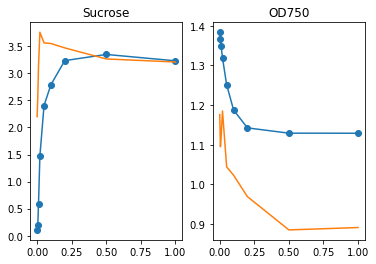

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 261.1999
Function value obtained: 1.8327
Current minimum: 1.8327
Iteration No: 20 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -2.3217137259979377,tau2: 0.1,c2: 5.0, mu: 1.62106157055994e-05


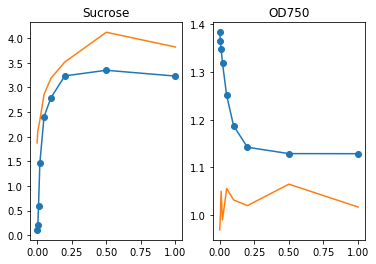

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 256.6648
Function value obtained: 1.3873
Current minimum: 1.3873
Iteration No: 21 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.06380975474453729,c: 0.0,alpha2: -2.359499017324314,tau2: 0.1,c2: 1.6045537496734874, mu: 1.707715547365785e-05


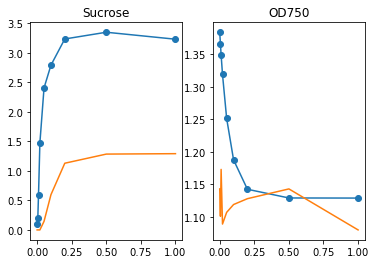

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 244.4587
Function value obtained: 1.8279
Current minimum: 1.3873
Iteration No: 22 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.5,alpha2: -1.789553462410808,tau2: 0.1,c2: 5.0, mu: 1.6621344361781744e-05


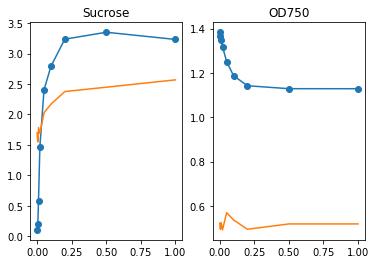

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 234.0465
Function value obtained: 1.7029
Current minimum: 1.3873
Iteration No: 23 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -3.8495966404135773,tau2: 0.06845545186389278,c2: 5.0, mu: 1.4975307896457853e-05


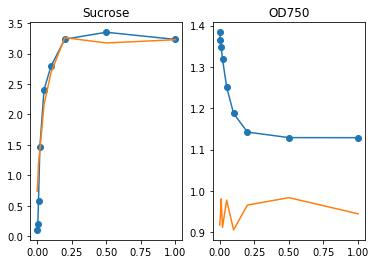

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 249.2141
Function value obtained: 0.7122
Current minimum: 0.7122
Iteration No: 24 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.28354636504942843,alpha2: -5.0,tau2: 0.01,c2: 5.0, mu: 1.4083685079973886e-05


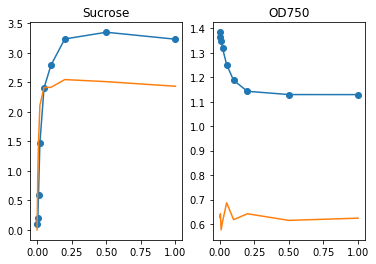

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 225.4700
Function value obtained: 1.2798
Current minimum: 0.7122
Iteration No: 25 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.021694673133614575,c: 0.16731514832930258,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.5706511546443e-05


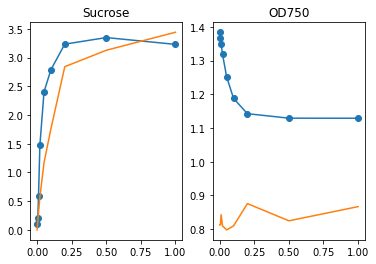

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 228.6153
Function value obtained: 1.0818
Current minimum: 0.7122
Iteration No: 26 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.0,alpha2: -4.223167907400209,tau2: 0.1,c2: 0.0, mu: 1.4386282622023363e-05


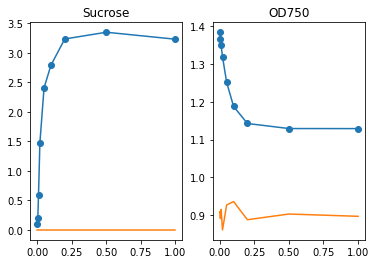

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 249.7932
Function value obtained: 2.6786
Current minimum: 0.7122
Iteration No: 27 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.06872869040051796,c: 0.0,alpha2: 0.0,tau2: 0.03858973981693798,c2: 0.0, mu: 3.019627576085846e-05


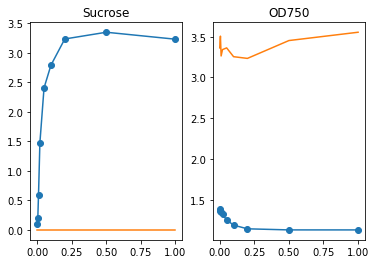

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 212.4612
Function value obtained: 4.4409
Current minimum: 0.7122
Iteration No: 28 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: 0.0,tau2: 0.1,c2: 5.0, mu: 1e-06


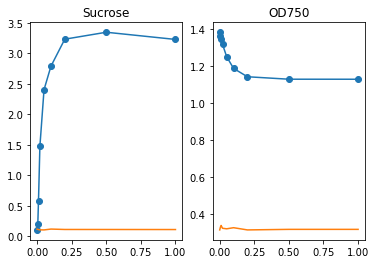

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 123.4662
Function value obtained: 3.1615
Current minimum: 0.7122
Iteration No: 29 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06973529448077617,c2: 5.0, mu: 1.6602877991693032e-05


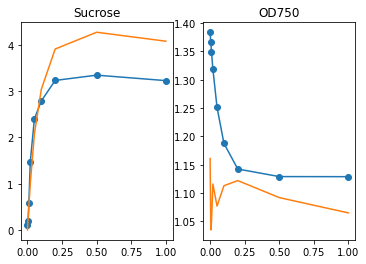

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 241.0670
Function value obtained: 0.7165
Current minimum: 0.7122
Iteration No: 30 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.09920613821081564,c2: 5.0, mu: 1.6590622483467812e-05


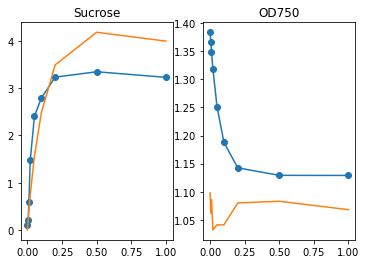

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 237.9990
Function value obtained: 0.7627
Current minimum: 0.7122
Iteration No: 31 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.6535500478902065e-05


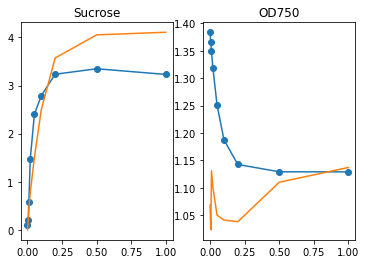

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 240.2607
Function value obtained: 0.7640
Current minimum: 0.7122
Iteration No: 32 started. Searching for the next optimal point.
alpha: -0.04138894850850222,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 5.0, mu: 1.6651098114769243e-05


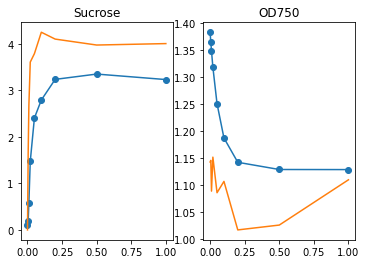

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 254.7936
Function value obtained: 1.5380
Current minimum: 0.7122
Iteration No: 33 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.5171153979384857e-05


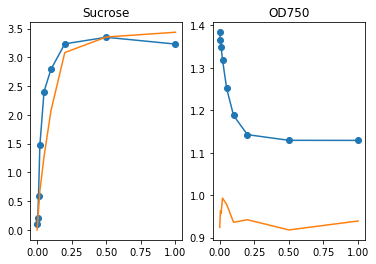

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 232.4161
Function value obtained: 0.8492
Current minimum: 0.7122
Iteration No: 34 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.3595961562550167,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.4859581559408433e-05


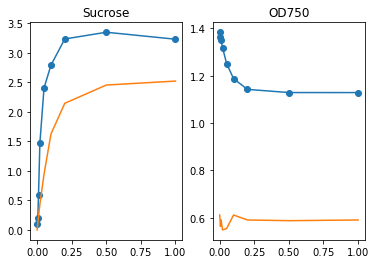

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 215.3258
Function value obtained: 1.5707
Current minimum: 0.7122
Iteration No: 35 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.0,alpha2: 0.0,tau2: 0.1,c2: 5.0, mu: 9.189636448004096e-06


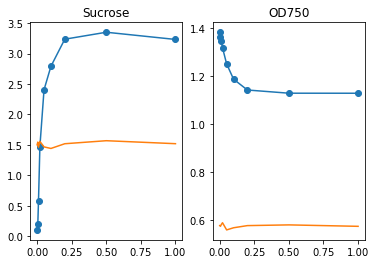

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 228.5061
Function value obtained: 2.0278
Current minimum: 0.7122
Iteration No: 36 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.6320194721876413e-05


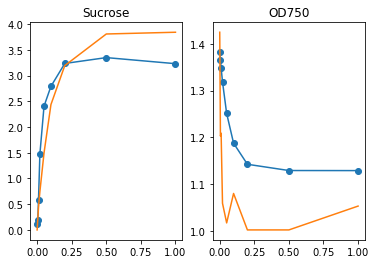

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 239.2766
Function value obtained: 0.6406
Current minimum: 0.6406
Iteration No: 37 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.09361570790991437,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.7191790003937758e-05


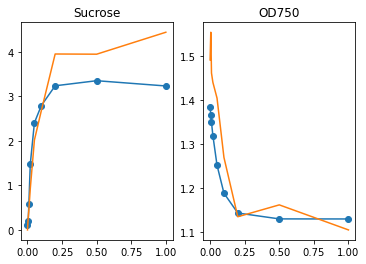

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 267.5726
Function value obtained: 0.6680
Current minimum: 0.6406
Iteration No: 38 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.691612493041956e-05


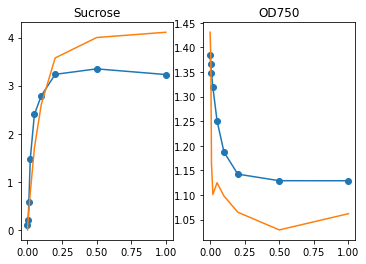

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 256.1819
Function value obtained: 0.6336
Current minimum: 0.6336
Iteration No: 39 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 0.0, mu: 2.932770026409881e-05


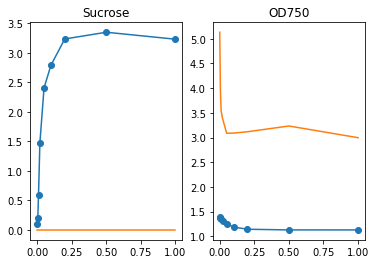

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 275.9167
Function value obtained: 4.6397
Current minimum: 0.6336
Iteration No: 40 started. Searching for the next optimal point.
alpha: -0.19417165485629814,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.07922303276263958,c2: 5.0, mu: 1.6643345960586194e-05


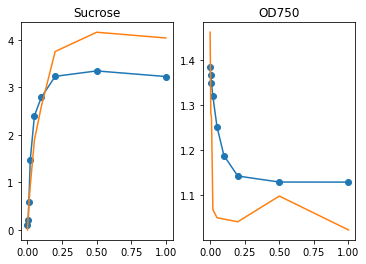

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 248.7886
Function value obtained: 0.6311
Current minimum: 0.6311
Iteration No: 41 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.07596366855038847,c2: 5.0, mu: 1.6445771307236284e-05


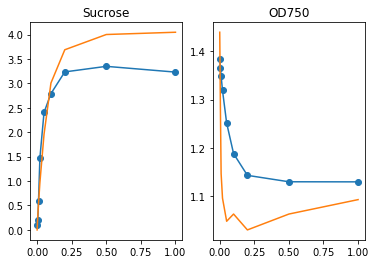

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 248.0723
Function value obtained: 0.5909
Current minimum: 0.5909
Iteration No: 42 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.028299276661683602,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 0.3107898937101824, mu: 3.0757742261884915e-05


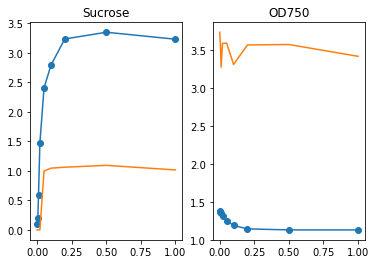

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 282.1469
Function value obtained: 3.8474
Current minimum: 0.5909
Iteration No: 43 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.04776124742654605,c: 0.0,alpha2: -5.0,tau2: 0.06976532701754222,c2: 5.0, mu: 1.5617813115293246e-05


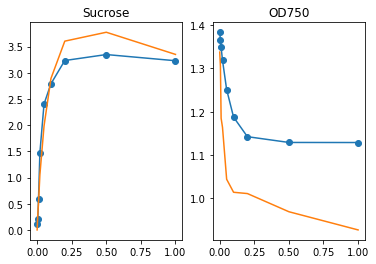

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 240.7637
Function value obtained: 0.4374
Current minimum: 0.4374
Iteration No: 44 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.023246602632787043,c: 0.0,alpha2: -5.0,tau2: 0.0662478938409335,c2: 5.0, mu: 1.5171738171410442e-05


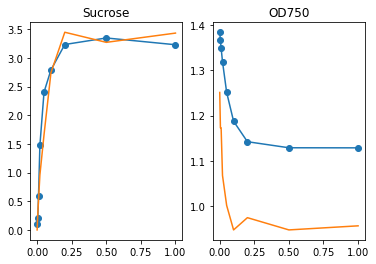

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 238.1962
Function value obtained: 0.5225
Current minimum: 0.4374
Iteration No: 45 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.09489463796330193,c: 0.0,alpha2: -5.0,tau2: 0.06892748979261222,c2: 4.999469992359716, mu: 1.553888234410381e-05


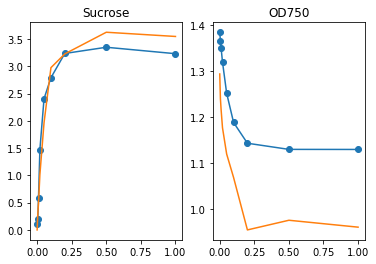

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 265.2998
Function value obtained: 0.4094
Current minimum: 0.4094
Iteration No: 46 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.064368205769633,c2: 4.874024775103873, mu: 1.5318134384390522e-05


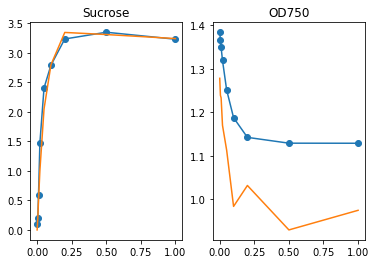

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 253.6137
Function value obtained: 0.3542
Current minimum: 0.3542
Iteration No: 47 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06577937298562374,c2: 4.726504866556987, mu: 1.531134919824533e-05


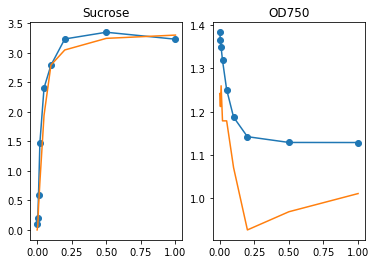

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 252.2963
Function value obtained: 0.4336
Current minimum: 0.3542
Iteration No: 48 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 1.7254890322057488, mu: 1.7997684580662104e-05


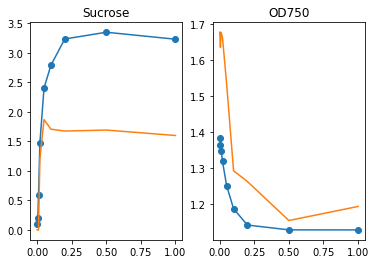

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 260.9447
Function value obtained: 1.2762
Current minimum: 0.3542
Iteration No: 49 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.5,alpha2: -5.0,tau2: 0.1,c2: 2.7415293683110598, mu: 1.921470502012201e-05


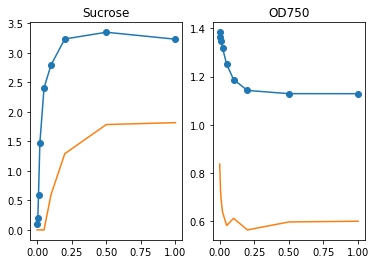

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 244.2172
Function value obtained: 2.1443
Current minimum: 0.3542
Iteration No: 50 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 0.0, mu: 1e-06


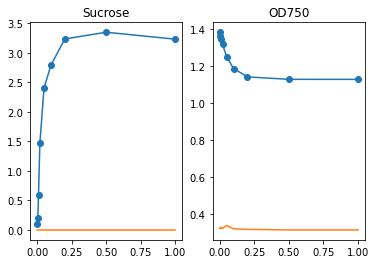

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 180.5978
Function value obtained: 3.2478
Current minimum: 0.3542
Iteration No: 51 started. Searching for the next optimal point.
alpha: -0.11348625654965216,tau: 0.1,c: 0.5,alpha2: 0.0,tau2: 0.01,c2: 1.4553736609180667, mu: 2.0189546717492956e-05


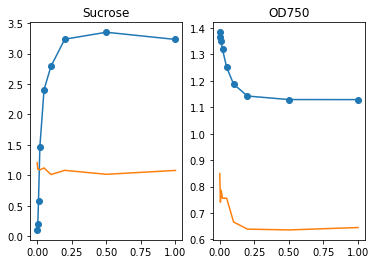

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 240.8859
Function value obtained: 2.0931
Current minimum: 0.3542
Iteration No: 52 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.0596771578829159,c2: 4.996960922431992, mu: 1.4755536376102024e-05


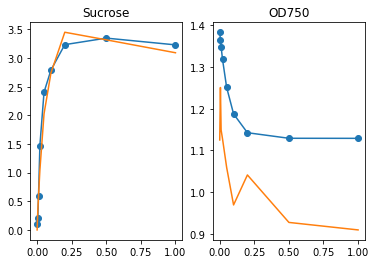

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 270.0762
Function value obtained: 0.4120
Current minimum: 0.3542
Iteration No: 53 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.5,alpha2: -5.0,tau2: 0.01,c2: 1.2480055615356376, mu: 1.4960102150745281e-05


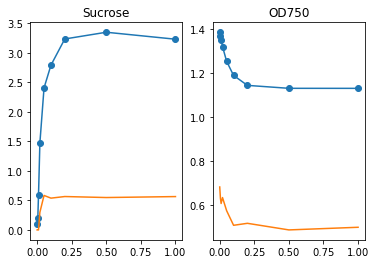

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 242.5778
Function value obtained: 2.5744
Current minimum: 0.3542
Iteration No: 54 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: 0.0,tau2: 0.1,c2: 1.5546223673872923, mu: 2.2775327344638085e-05


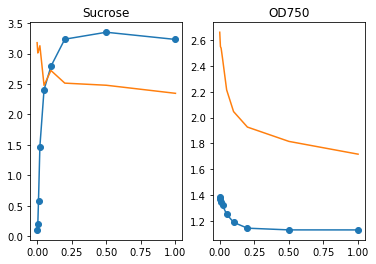

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 276.1607
Function value obtained: 2.7598
Current minimum: 0.3542
Iteration No: 55 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.03836896969470262,c2: 4.345752848842005, mu: 1.3932454662329046e-05


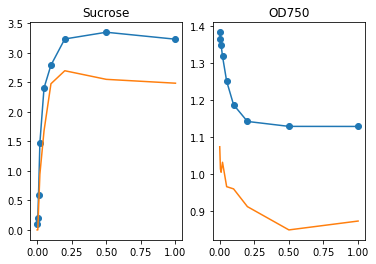

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 253.5162
Function value obtained: 0.8164
Current minimum: 0.3542
Iteration No: 56 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.011417092814777076,c: 0.5,alpha2: 0.0,tau2: 0.1,c2: 2.2868598792869808, mu: 1e-06


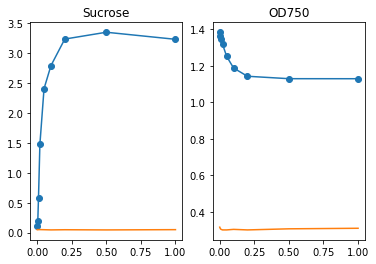

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 126.2001
Function value obtained: 3.2274
Current minimum: 0.3542
Iteration No: 57 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.1,c2: 3.945342172562914, mu: 1.6617631406357886e-05


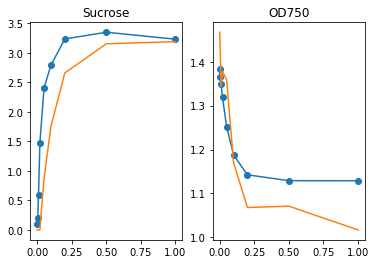

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 255.0493
Function value obtained: 0.9114
Current minimum: 0.3542
Iteration No: 58 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.5,alpha2: 0.0,tau2: 0.01,c2: 5.0, mu: 7.098916071975242e-06


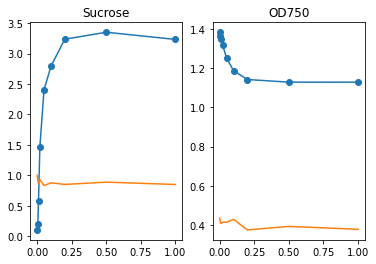

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 212.6105
Function value obtained: 2.5215
Current minimum: 0.3542
Iteration No: 59 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 1.3113979666921807, mu: 2.1615965953090683e-05


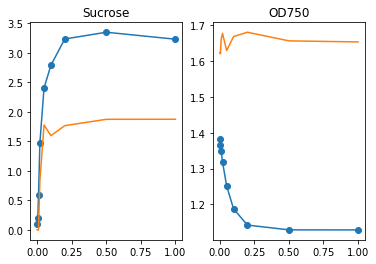

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 281.6875
Function value obtained: 1.4048
Current minimum: 0.3542
Iteration No: 60 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: 0.0,tau2: 0.1,c2: 2.6492613918207955, mu: 1.1148749691778679e-05


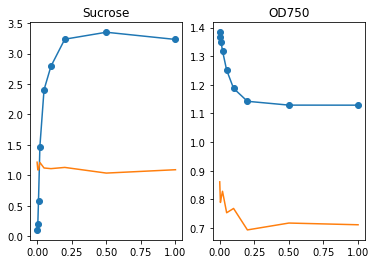

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 244.5979
Function value obtained: 2.0172
Current minimum: 0.3542
Iteration No: 61 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.04647699273260433,c2: 3.198454982479526, mu: 1.6668720664767215e-05


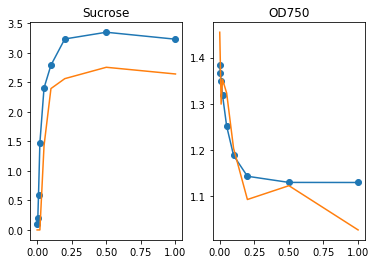

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 277.9865
Function value obtained: 0.7878
Current minimum: 0.3542
Iteration No: 62 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.5,alpha2: -5.0,tau2: 0.042187750394805254,c2: 5.0, mu: 1.62597501074994e-05


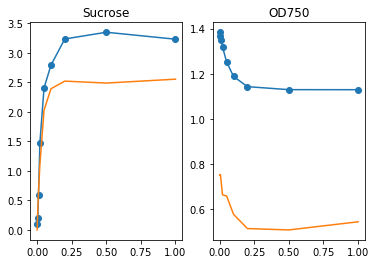

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 232.4608
Function value obtained: 1.1116
Current minimum: 0.3542
Iteration No: 63 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.0581800766067266,c2: 4.038779602438568, mu: 1.541771761193751e-05


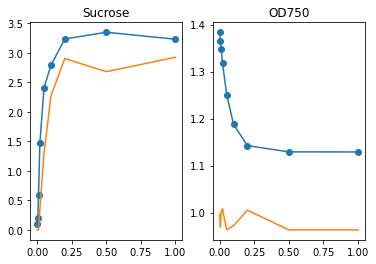

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 264.7738
Function value obtained: 0.9314
Current minimum: 0.3542
Iteration No: 64 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.5,alpha2: -5.0,tau2: 0.1,c2: 1.5843792851929928, mu: 2.8439024881154456e-05


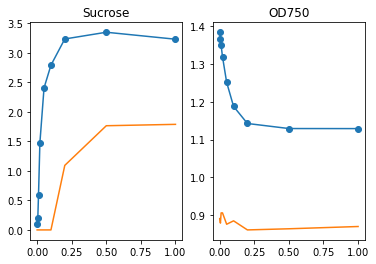

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 275.1095
Function value obtained: 2.0564
Current minimum: 0.3542
Iteration No: 65 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06497095009954236,c2: 2.6777614084455212, mu: 1.4608497725174789e-05


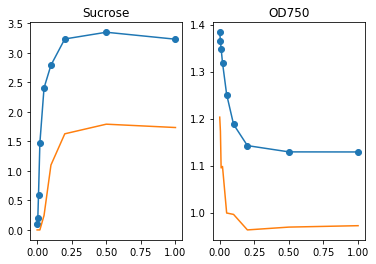

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 245.7422
Function value obtained: 1.5896
Current minimum: 0.3542
Iteration No: 66 started. Searching for the next optimal point.
alpha: -0.06440349721494115,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 2.847829065462064, mu: 1.9026920710955384e-05


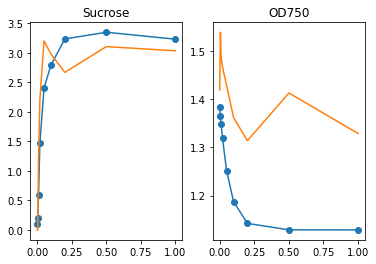

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 261.6615
Function value obtained: 0.6519
Current minimum: 0.3542
Iteration No: 67 started. Searching for the next optimal point.
alpha: -0.06730334235793778,tau: 0.1,c: 0.5,alpha2: -5.0,tau2: 0.01,c2: 3.156464534974127, mu: 1.8210515142944933e-05


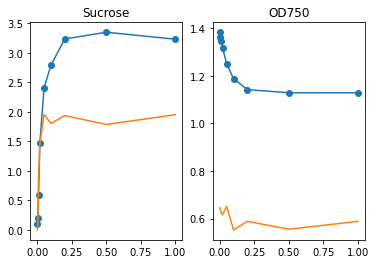

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 237.8672
Function value obtained: 1.5330
Current minimum: 0.3542
Iteration No: 68 started. Searching for the next optimal point.
alpha: -0.15975073041148058,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.04120604065822565,c2: 2.645600424940076, mu: 1.9556952790568736e-05


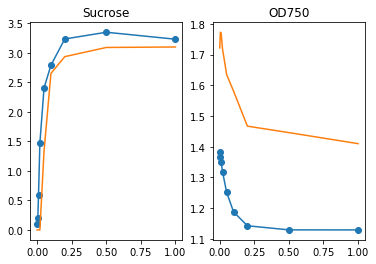

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 267.2325
Function value obtained: 1.0242
Current minimum: 0.3542
Iteration No: 69 started. Searching for the next optimal point.
alpha: -0.015943894514582085,tau: 0.1,c: 0.0,alpha2: 0.0,tau2: 0.01,c2: 2.5011692793094715, mu: 1.7125784141003553e-05


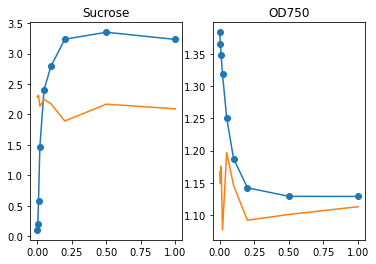

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 255.5769
Function value obtained: 1.5390
Current minimum: 0.3542
Iteration No: 70 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.5,alpha2: 0.0,tau2: 0.1,c2: 0.0, mu: 1e-06


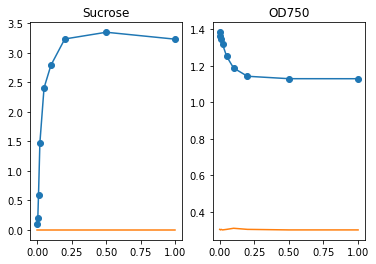

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 40.1918
Function value obtained: 3.2692
Current minimum: 0.3542
Iteration No: 71 started. Searching for the next optimal point.
alpha: -0.06378738762228636,tau: 0.1,c: 0.5,alpha2: 0.0,tau2: 0.1,c2: 0.0, mu: 1.4095636830955592e-05


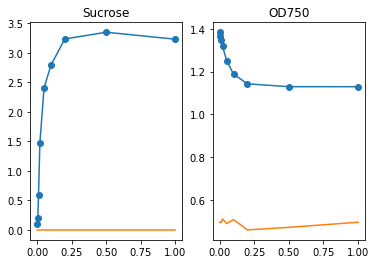

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 129.2364
Function value obtained: 3.0816
Current minimum: 0.3542
Iteration No: 72 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.024056923046971018,c: 0.0,alpha2: -5.0,tau2: 0.07008088033914443,c2: 5.0, mu: 1.4202634751447549e-05


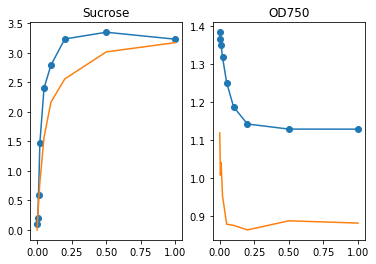

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 232.6047
Function value obtained: 0.7963
Current minimum: 0.3542
Iteration No: 73 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.08195637860866334,c2: 5.0, mu: 1.53188267015947e-05


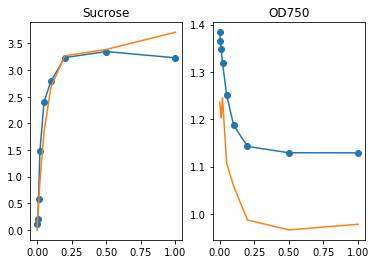

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 239.7915
Function value obtained: 0.4626
Current minimum: 0.3542
Iteration No: 74 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.0,alpha2: 0.0,tau2: 0.01,c2: 2.1324919563898925, mu: 1e-06


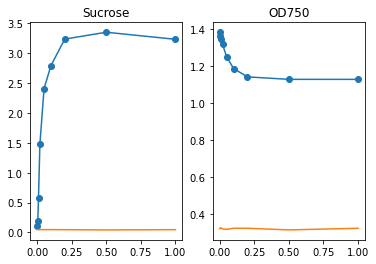

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 117.1093
Function value obtained: 3.2108
Current minimum: 0.3542
Iteration No: 75 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.1,c: 0.5,alpha2: 0.0,tau2: 0.01,c2: 1.5530843162888155, mu: 2.9833571702317896e-05


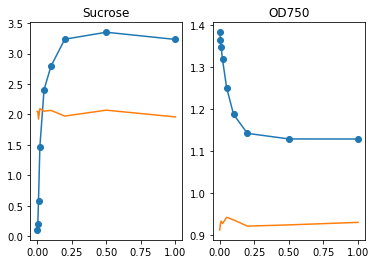

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 256.5067
Function value obtained: 1.6244
Current minimum: 0.3542
Iteration No: 76 started. Searching for the next optimal point.
alpha: -0.010480014863605447,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 2.7956459092079387, mu: 1.8073051453547218e-05


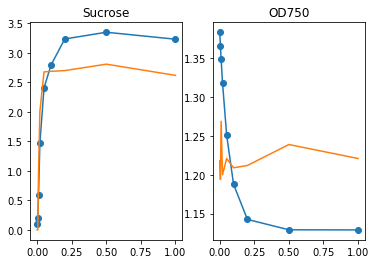

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 265.4216
Function value obtained: 0.5183
Current minimum: 0.3542
Iteration No: 77 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.5,alpha2: -5.0,tau2: 0.01,c2: 1.5369153030439773, mu: 2.499965722113508e-05


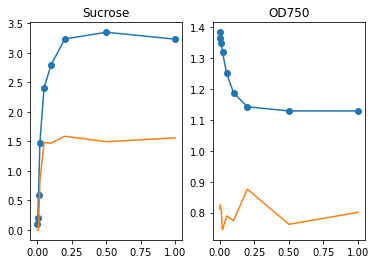

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 248.4484
Function value obtained: 1.6368
Current minimum: 0.3542
Iteration No: 78 started. Searching for the next optimal point.
alpha: -0.025355759138550205,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 3.012614987054719, mu: 1.6985794675745555e-05


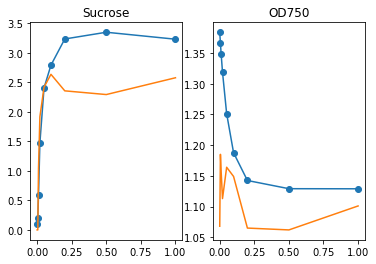

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 265.3161
Function value obtained: 0.7176
Current minimum: 0.3542
Iteration No: 79 started. Searching for the next optimal point.
alpha: -0.19505612963196808,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 3.02665127318713, mu: 1.8206078694281046e-05


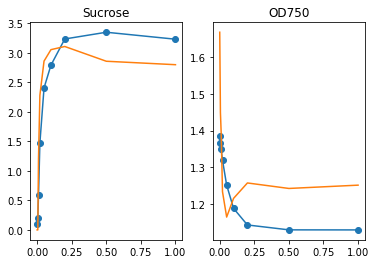

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 265.1315
Function value obtained: 0.5756
Current minimum: 0.3542
Iteration No: 80 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.07078321026415742,c: 0.5,alpha2: 0.0,tau2: 0.1,c2: 1.682708937437691, mu: 3.1539794731468627e-05


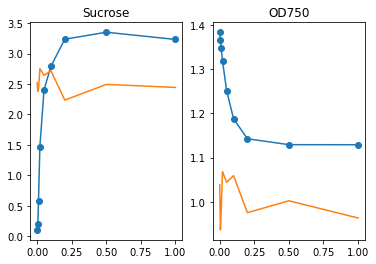

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 264.6875
Function value obtained: 1.6791
Current minimum: 0.3542
Iteration No: 81 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.5,alpha2: 0.0,tau2: 0.01,c2: 0.0, mu: 6.358635823332656e-06


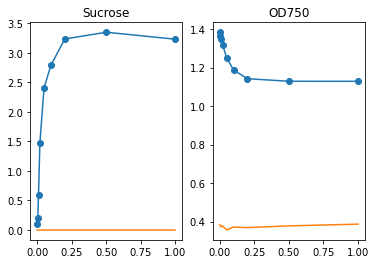

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 82.7002
Function value obtained: 3.1965
Current minimum: 0.3542
Iteration No: 82 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.5,alpha2: -5.0,tau2: 0.1,c2: 5.0, mu: 1.969234467158026e-05


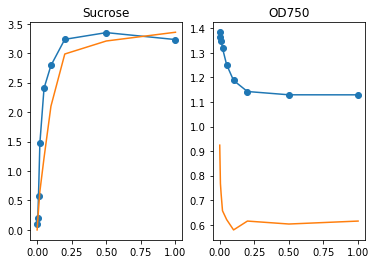

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 226.3943
Function value obtained: 1.1250
Current minimum: 0.3542
Iteration No: 83 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 2.4138226489648695, mu: 1.990338606401428e-05


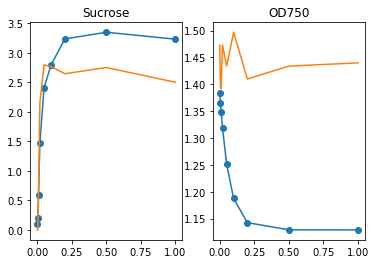

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 262.9610
Function value obtained: 0.6768
Current minimum: 0.3542
Iteration No: 84 started. Searching for the next optimal point.
alpha: -2.2359463232674015e-05,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 5.0, mu: 9.815301563728709e-06


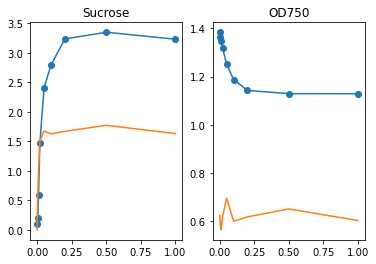

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 215.4773
Function value obtained: 1.6841
Current minimum: 0.3542
Iteration No: 85 started. Searching for the next optimal point.
alpha: -0.13154183113757786,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05996289898393921,c2: 5.0, mu: 1.5196431541153697e-05


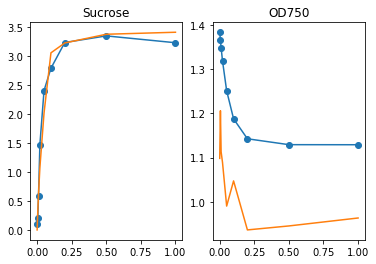

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 240.4411
Function value obtained: 0.4341
Current minimum: 0.3542
Iteration No: 86 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06035413837920155,c2: 4.928459422673988, mu: 1.5388168537943844e-05


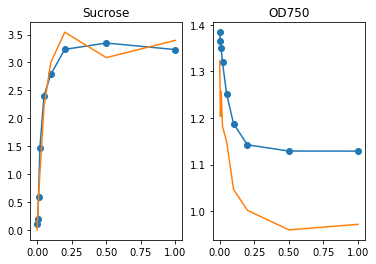

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 256.3316
Function value obtained: 0.3691
Current minimum: 0.3542
Iteration No: 87 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06021897451217185,c2: 4.927662644776397, mu: 1.5362475220009533e-05


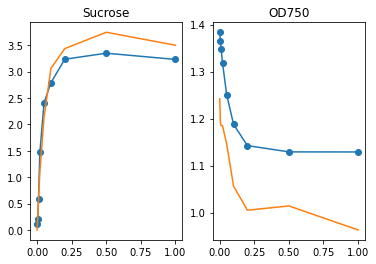

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 253.8851
Function value obtained: 0.3950
Current minimum: 0.3542
Iteration No: 88 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.01,c2: 2.60825993783399, mu: 1.835393461488222e-05


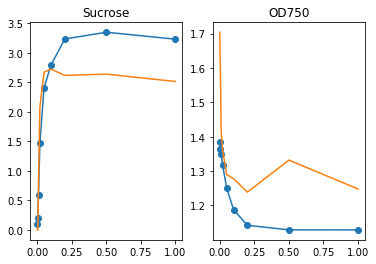

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 270.6388
Function value obtained: 0.6251
Current minimum: 0.3542
Iteration No: 89 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06775025735715356,c2: 4.9289315938928375, mu: 1.528851784142444e-05


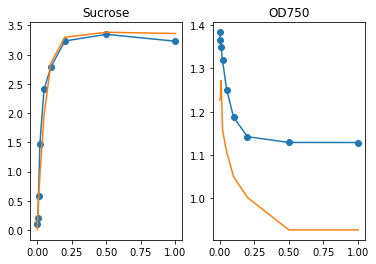

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 253.7650
Function value obtained: 0.4012
Current minimum: 0.3542
Iteration No: 90 started. Searching for the next optimal point.
alpha: 0.0,tau: 0.01,c: 0.0,alpha2: -5.0,tau2: 0.030709085644467532,c2: 3.1428071817946335, mu: 1.8338700972512677e-05


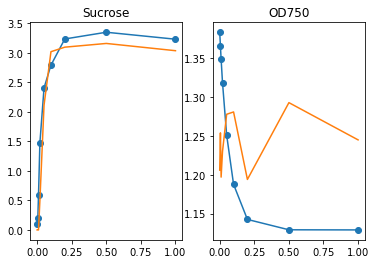

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 265.9089
Function value obtained: 0.5375
Current minimum: 0.3542
Iteration No: 91 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06993480813410022,c2: 5.0, mu: 1.5375027896042045e-05


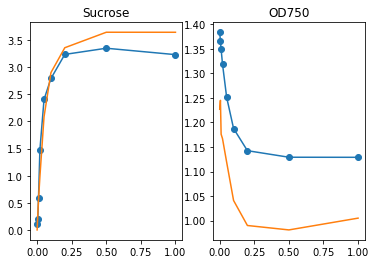

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 239.6961
Function value obtained: 0.4150
Current minimum: 0.3542
Iteration No: 92 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05908182647105927,c2: 4.8825944603977325, mu: 1.5378408950068647e-05


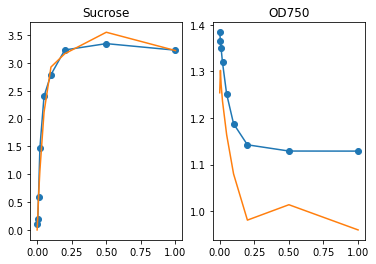

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 251.1457
Function value obtained: 0.3075
Current minimum: 0.3075
Iteration No: 93 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05499156838080309,c2: 4.897565713832043, mu: 1.5243165134200467e-05


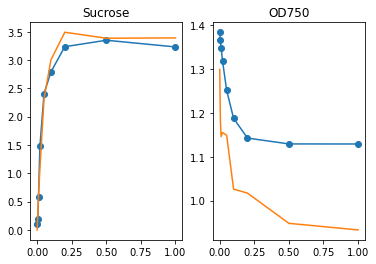

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 255.1412
Function value obtained: 0.3492
Current minimum: 0.3075
Iteration No: 94 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05293020748954671,c2: 4.756606717921747, mu: 1.5503876157435656e-05


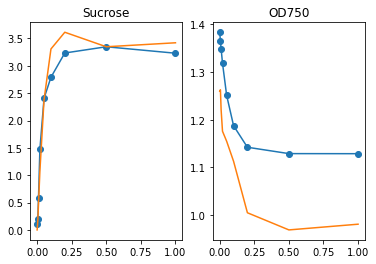

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 251.0551
Function value obtained: 0.3919
Current minimum: 0.3075
Iteration No: 95 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05705423347447056,c2: 4.842195112177309, mu: 1.5331316215651807e-05


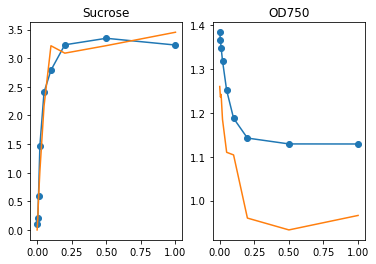

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 256.3310
Function value obtained: 0.3890
Current minimum: 0.3075
Iteration No: 96 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.06700118037768939,c2: 4.898391277477705, mu: 1.5414783448126176e-05


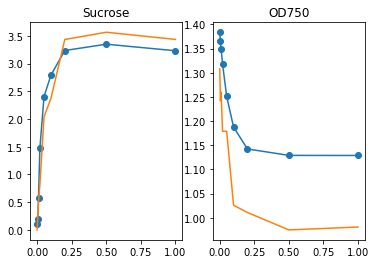

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 253.7454
Function value obtained: 0.4400
Current minimum: 0.3075
Iteration No: 97 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05614884531304679,c2: 5.0, mu: 1.5259977477247026e-05


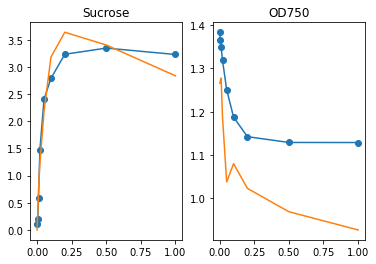

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 242.7577
Function value obtained: 0.4087
Current minimum: 0.3075
Iteration No: 98 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05680758855901981,c2: 4.839646428833982, mu: 1.5329021152164007e-05


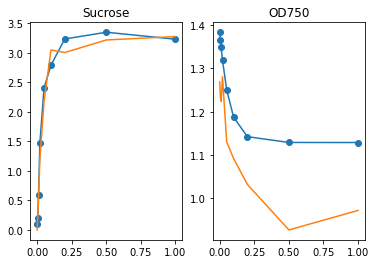

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 259.2259
Function value obtained: 0.3047
Current minimum: 0.3047
Iteration No: 99 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.05704543487316867,c2: 4.787311456162594, mu: 1.544154946859376e-05


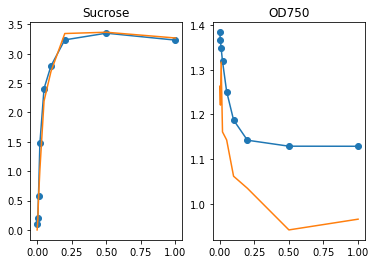

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 259.0986
Function value obtained: 0.3123
Current minimum: 0.3047
Iteration No: 100 started. Searching for the next optimal point.
alpha: -0.2,tau: 0.1,c: 0.0,alpha2: -5.0,tau2: 0.0573333860602963,c2: 4.707188899026856, mu: 1.561727234036961e-05


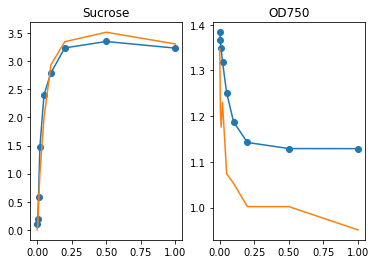

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 252.4566
Function value obtained: 0.3796
Current minimum: 0.3047


In [15]:

alpha_min = float('-2e-1')
alpha_max = float('0')
tau_min = float('1e-2')
tau_max = float('1e-1')
c_min = float('0')
c_max = float('5e-1')
alpha2_min = float('-1e1')
alpha2_max = float('0')
tau2_min = float('1e-2')
tau2_max = float('1e-1')
c2_min = float('0')
c2_max = float('1e1')

mu_min = float('1e-6')
mu_max = float('5e-5')

bounds = [(alpha_min,alpha_max),(tau_min,tau_max),(c_min,c_max),(alpha2_min,alpha2_max),(tau2_min,tau2_max),(c2_min,c2_max),(mu_min,mu_max)]#,



checkpoint_saver = CheckpointSaver('/home/12x/nufeb-cyano-e-coli/checkpoints/checkpoint-se.pkl', compress=9) # keyword arguments will be passed to `skopt.dump`
n_calls = 100
#res = forest_minimize(func, bounds, n_calls=n_calls,callback=[tqdm_skopt(total=n_calls, desc="Random forest")],base_estimator="ET",verbose=True)
res = gp_minimize(func, bounds, n_calls=n_calls,verbose=True,callback=[checkpoint_saver])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

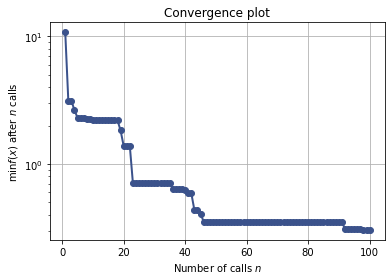

In [16]:
plot_convergence(res,yscale='log')

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{4}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{4}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<A

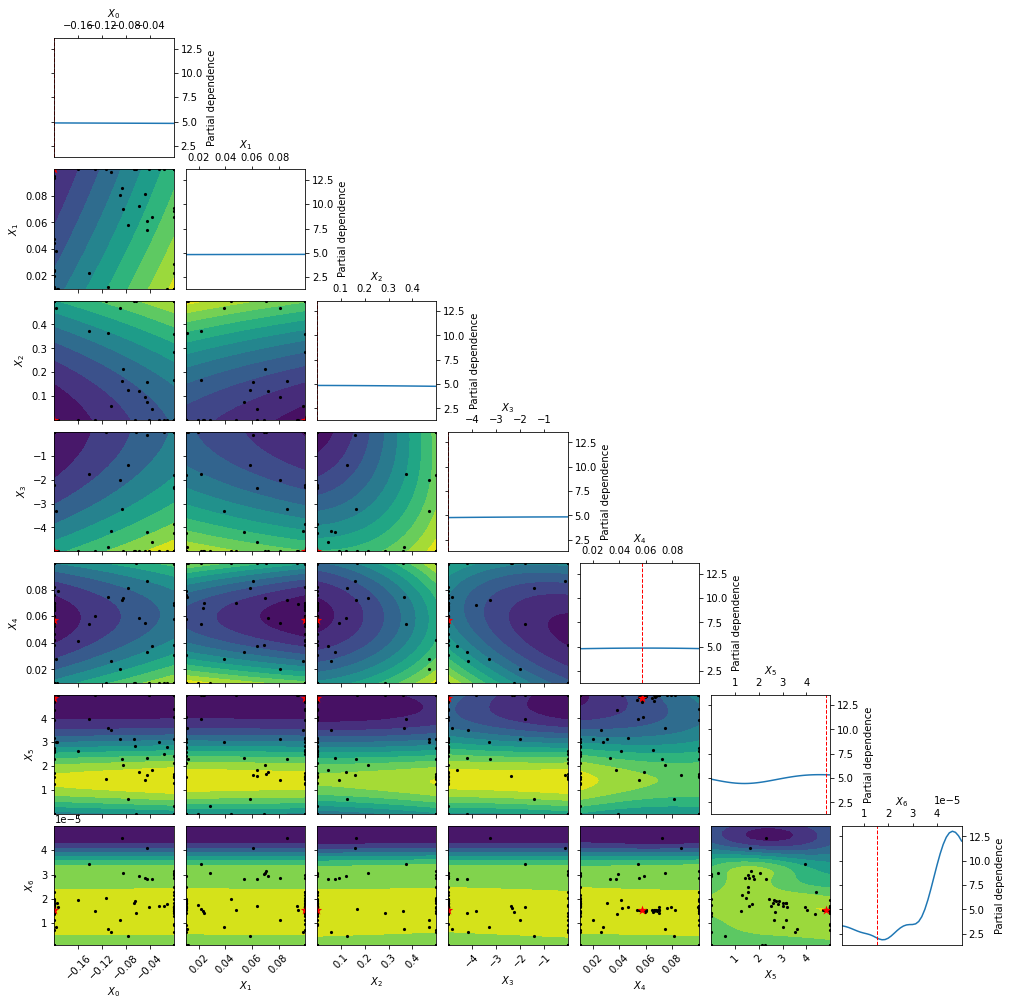

In [17]:
plot_objective(res)

In [18]:
res.x

[-0.2,
 0.1,
 0.0,
 -5.0,
 0.05680758855901981,
 4.839646428833982,
 1.5329021152164007e-05]

In [ ]:
os.chdir('/tmp/NUFEB')
recompile(res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],res.x[5])

#Clean old simulations
os.system('nufeb-clean')
#Run simulation
for iptg in test_data.IPTG:
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {res.x[6]} --sucR {iptg}}'
    os.system(text)

run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

#Extract output

data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-4 #m^3
CellNum2OD = Volume*1e6/0.3e-8
SucroseMW = 342.3
dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['IPTG'] = x.metadata['SucRatio']
    dfs.append(temp)
df = pd.concat(dfs,ignore_index=True)
df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
df.sort_values(by='IPTG',inplace=True)
df.reset_index(inplace=True)

In [ ]:
f, ax = plt.subplots(ncols=2)
ax[0].set_title('Sucrose')
ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
ax[0].plot(df.IPTG,df.Sucrose)
ax[1].set_title('OD750')
ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
ax[1].plot(df.IPTG,df.OD750)

In [ ]:


dump(res, 'result.pkl')